Data Cleaning

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint

<h1>Data Preprocessing and Scaling</h1>

In [52]:
# Load dataset
dataset = pd.read_csv('Survival_Data.csv')

In [53]:
#Drop undesired features
dataset = dataset.drop(['studyid', 'site', 'strength_comfort_religion', 'petition_prayer_health', 'intercessory_prayers_health'], axis = 1)

In [54]:
# Separate the dataset into numerical and categorical features
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = dataset.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

In [55]:
# Use median imputation on the numerical features for missing values
dataset[numerical_features] = dataset[numerical_features].fillna(dataset[numerical_features].median())

# Use mode imputation on the categorical features for missing values
for col in categorical_features:
    dataset[col] = dataset[col].fillna(dataset[col].mode().iloc[0])

In [56]:
# Convert binary categorical variables ('Yes'/'No') into 1/0
binary_columns = [col for col in categorical_features if dataset[col].nunique() == 2]
for col in binary_columns:
    unique_values = dataset[col].unique()
    if set(unique_values) == {'Yes', 'No'}:
        dataset[col] = dataset[col].replace({'Yes': 1, 'No': 0})
    elif set(unique_values) == {'Not impaired', 'Impaired'}:
        dataset[col] = dataset[col].replace({'Impaired': 1, 'Not impaired': 0})
    else:
        mapping = {unique_values[0]: 1, unique_values[1]: 0}
        dataset[col] = dataset[col].map(mapping)


# Remaining categorical variables (multi-category)
multi_category_columns = [col for col in categorical_features if col not in binary_columns]

In [57]:
# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(dataset[multi_category_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(multi_category_columns))

In [58]:
# Drop original categorical columns and merge encoded ones
dataset = dataset.drop(multi_category_columns, axis=1)
dataset = pd.concat([dataset, encoded_categorical_df], axis=1)

In [59]:
# Separate features and target
X = dataset.drop('died_2_year', axis=1)
y = dataset['died_2_year']

In [60]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [61]:
# Split into Train (80%), Validation (10%), and Test (10%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

<h3>Model: RandomForest Classifier</h3>

In [62]:
param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(3, 7),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(5, 20),
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Get best model based on the params
best_rfc = random_search.best_estimator_

# Evaluate model
train_score = np.mean(cross_val_score(best_rfc, X_train, y_train, cv=5))
val_score = best_rfc.score(X_val, y_val)
test_score = best_rfc.score(X_test, y_test)

# Output results
print("Best Parameters:", random_search.best_params_)
print("Train Score:", train_score)
print("Validation Score:", val_score)
print("Test Score:", test_score)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 64}
Train Score: 0.9419591687265403
Validation Score: 0.9710144927536232
Test Score: 0.9420289855072463


In [64]:
y_pred = best_rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       194
           1       1.00      0.08      0.14        13

    accuracy                           0.94       207
   macro avg       0.97      0.54      0.56       207
weighted avg       0.95      0.94      0.92       207



Evaluation Visualization

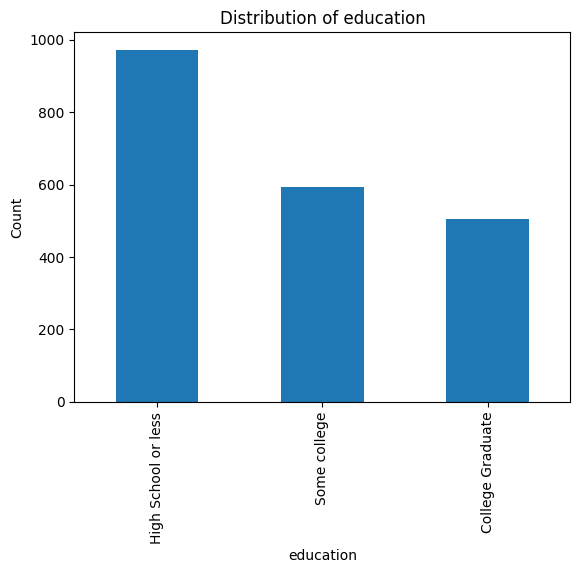

In [12]:
#Displays a bar plot of any desired input in the column
def target_dist(df, colname):
  if colname not in df.columns:
    print("Column did not exist in DataFrame")
    return
  values = df[colname].value_counts()
  #Plot it
  plt.figure()
  values.plot(kind='bar')
  plt.title(f"Distribution of {colname}")
  plt.xlabel(colname)
  plt.ylabel("Count")
  plt.show()

target_dist(dataset, 'education')

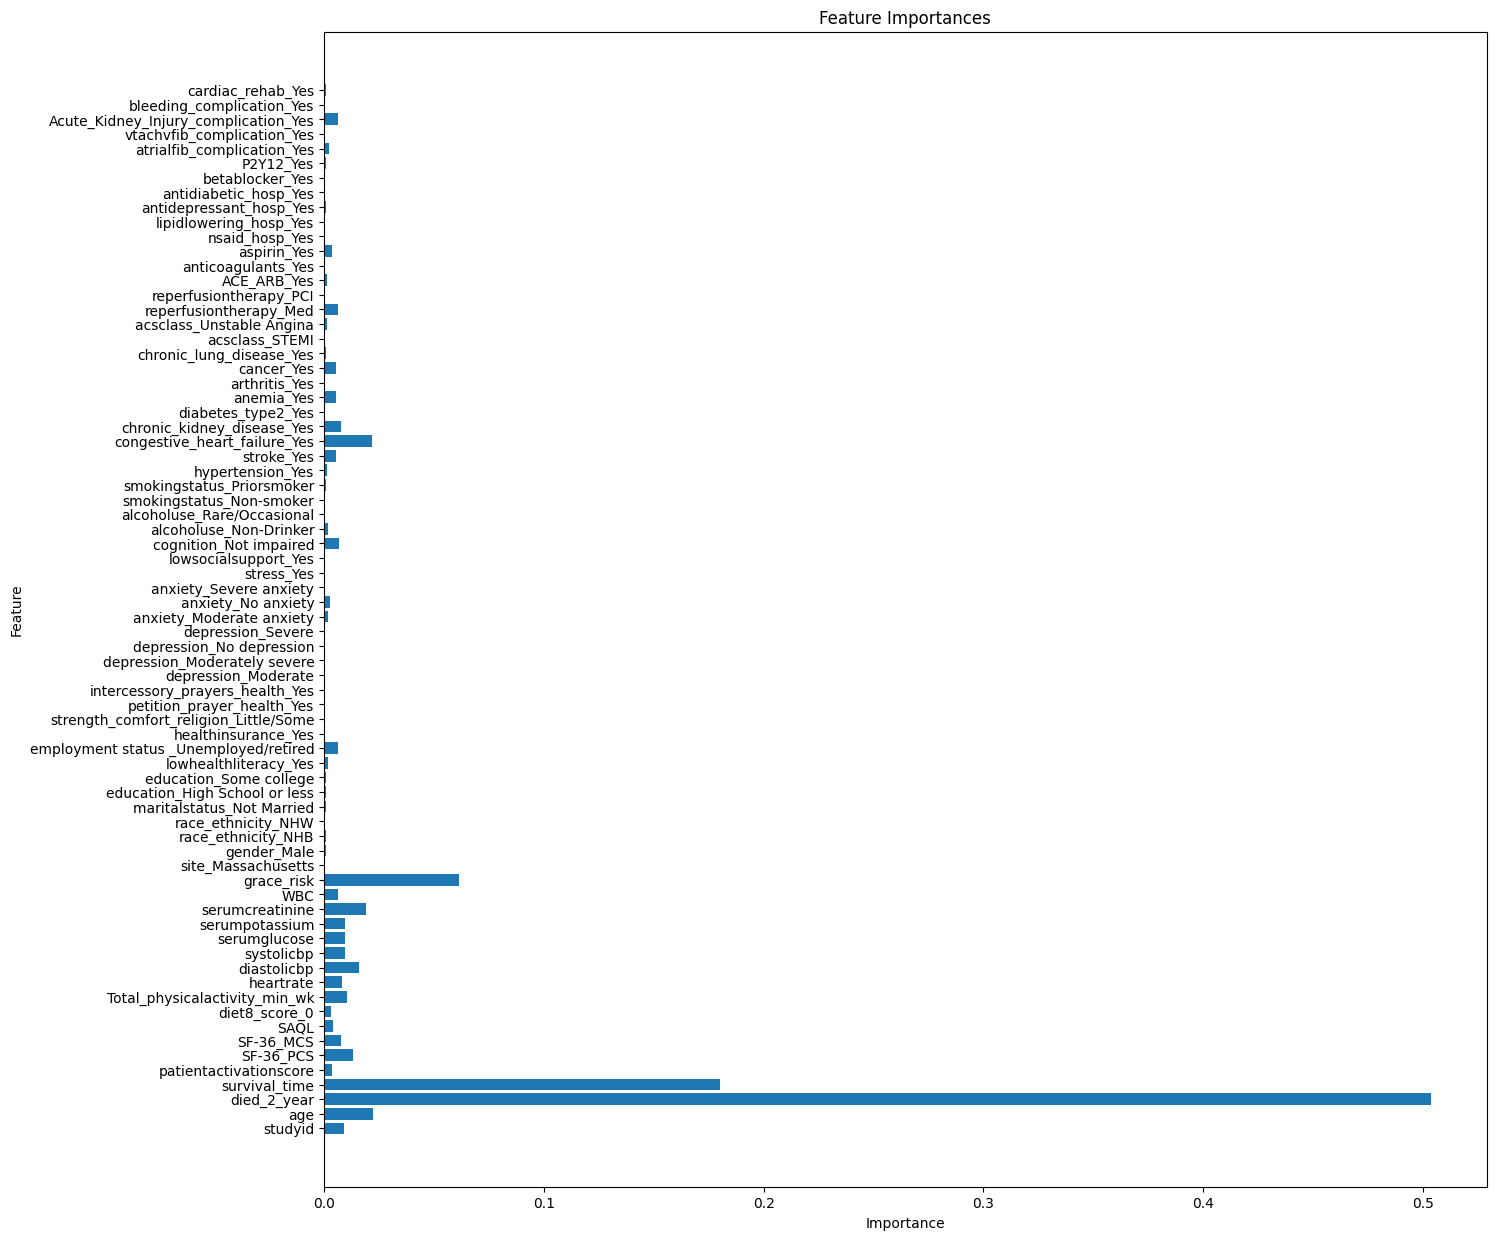

In [13]:
#Display a feature importance of each column in predicting y
feature_importance = best_rfc.feature_importances_
feature_names = X_train.columns

#Plot
plt.figure(figsize=(15,15))
plt.barh(feature_names, feature_importance)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

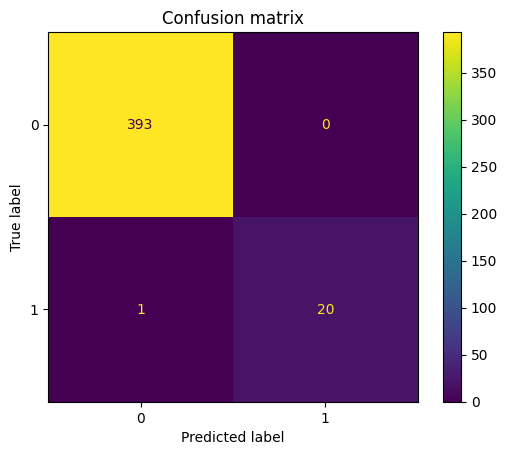

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix")
plt.show()

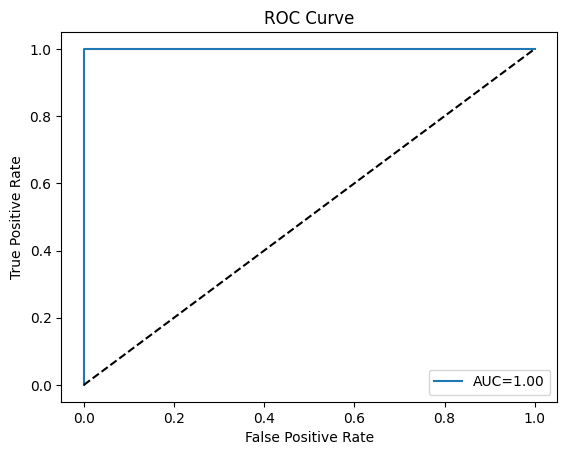

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
#Create ROC Curve
y_proba = best_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1], 'k--') #Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

Comparing Different Models

Neural Networks

In [16]:
import tensorflow as tf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, input_shape=X_train.shape[1:], activation = 'sigmoid'))
model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=100)

In [20]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9287 - loss: 0.2582 


[0.20127105712890625, 0.9492753744125366]

Gradient Boosting Machine

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

model = xgb.XGBClassifier(random_state=42)
#Initialize XGBoost Classifier
param_grid = {
    'n_estimators': [50, 100],  # Number of boosting rounds (trees)
    'max_depth': [3, 5, 7],            # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3], # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],      # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],# Fraction of features used for training each tree
    'reg_alpha': [0.1, 0.5],    # L1 regularization term
    'reg_lambda': [0.1, 0.5]    # L2 regularization term
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42)
#Perform search
random_search.fit(X_train, y_train)

#Print out results
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

#Get the best_estimators
best_gbm = random_search.best_estimator_

#Make predictions
y_pred = best_gbm.predict(X_test)
gbm_accuracy = accuracy_score(y_test, y_pred)
# Likely overfit
print("GBM Accuracy:", gbm_accuracy)




Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters:  {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Best score:  1.0
GBM Accuracy: 1.0


Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lr = LogisticRegression(C=3, penalty = 'l2', solver = 'liblinear', max_iter = 200)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.5f}".format(lr_accuracy))


Accuracy: 0.98792


Support Vector Machine

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

svc = SVC(C = 1, kernel = 'linear', gamma = 'scale', verbose = 1, random_state=42)

svc.fit(X_train, y_train)


y_pred = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", svc_accuracy)

[LibSVM]Accuracy:  0.9637681159420289
